In [1]:
import os.path
import math
import re

from collections import Counter, defaultdict

import pandas as pd
import numpy as np
%matplotlib inline

from pymongo import MongoClient

from newsparser.data import load_feeds
from newsbreaker.data import load_entries, save_entries

from newsbreaker import init

folder = os.path.join('..', 'data')
init(os.path.join(folder, 'topic_model'), 'topic_model.pkl', 'vocab.txt') 

# Define dataset

In [2]:
feeds = load_feeds(folder)

In [3]:
entries = load_entries(folder)

In [4]:
entries2 = {
    feed.name: []
    for feed in feeds
}

for entry in entries:
    entries2[entry.feedname].append(entry)

entries = entries2
del entries2

In [5]:
client = MongoClient()
politics = client.newstagger.politics

In [6]:
tagged_entries = set()

for d in politics.find():
    feedname, index = d['entry'].split('|')
    index = int(index)
        
    for entry in entries[feedname]:
        if entry.index == index:
            entry.politics = d['res']
            tagged_entries.add(entry)
            break
            
tagged_entries = list(tagged_entries)

# Define Counter, Vocab, TF-IDF, WORDS

In [7]:
for entry in tagged_entries:
    entry.doc(tag=False, parse=False, entity=False)
    
    entry.counter = Counter(
        w.lower_
        for w in entry.doc
        if w.is_alpha
    )

In [8]:
vocab = {
    w
    for entry in tagged_entries
    for w in entry.counter
}

In [9]:
idf = {
    w: math.log(
        len(tagged_entries) / sum(
            w in entry.counter
            for entry in tagged_entries
        )
    )
    for w in vocab
}

In [10]:
for entry in tagged_entries:
    s = sum(entry.counter.values())
    
    if s:
        entry.tf_idf = {
            w: (n / s) * idf[w]
            for w, n in entry.counter.items()
        }
    else:
        entry.tf_idf = {}

In [11]:
WORDS = set()

# 10 most relevant words of every entry
for entry in tagged_entries:
    WORDS.update(
        map(
            lambda pair: pair[0], 
            sorted(entry.tf_idf.items(), key=lambda pair: pair[1], reverse=True)[:10]
        )
    )

In [12]:
len(WORDS)

6313

In [14]:
# 1000 most common of those words
WORDS = sorted(WORDS, key=lambda w: idf[w], reverse=False)[:1000]

# Define models

http://scikit-learn.org/stable/modules/cross_validation.html

The mean score and the 95% confidence interval of the score estimate are hence given by:

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [15]:
def get_scores(models, as_df=False):
    dfs = []
    
    for model in models:
        clf = model['clf']()
        X = model['X']

        scores = cross_validation.cross_val_score(
            clf, X, Y, cv=cross_validation_K
        )

        if as_df:
            dfs.append([model['name'], scores.mean(), scores.std() * 2])
        else:
            print(model['name'] + ':', scores.mean(), scores.std() * 2)
            
    if as_df:
        return pd.DataFrame(
            dfs, 
            columns=['name', 'scores_mean', 'scores_confidence_interval']
        )

In [16]:
cross_validation_K = 5

## BernoulliNB/MultinomialNB with WORDS

In [17]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [18]:
X_BOW = np.array(
    [
        [
            w in entry.counter
            for w in WORDS
        ]
        
        for entry in tagged_entries
    ]
)

X_Counter = np.array(
    [
        [
            entry.counter.get(w, 0)
            for w in WORDS
        ]
        
        for entry in tagged_entries
    ]
)

X_TF_IDF = np.array(
    [
        [
            entry.tf_idf.get(w, 0)
            for w in WORDS
        ]
        
        for entry in tagged_entries
    ]
)

Y = np.array(
    [
        entry.politics
        for entry in tagged_entries
    ]
)

In [19]:
models = [
    { 'name': 'Bernoulli', 'clf': BernoulliNB, 'X': X_BOW },
    { 'name': 'Multinomial with counter', 'clf': MultinomialNB, 'X': X_Counter },
    { 'name': 'Multinomial with TF-IDF', 'clf': MultinomialNB, 'X': X_TF_IDF }
]

get_scores(models)

Bernoulli: 0.890620031797 0.0293854713008
Multinomial with counter: 0.917462060991 0.00572268131756
Multinomial with TF-IDF: 0.861743026449 0.00312183841596


## Random Forests with WORDS

In [20]:
from sklearn.ensemble import RandomForestClassifier
from functools import partial

In [21]:
n_trees_interval = [1, 50]
max_depth_interval = [1, 20]

In [22]:
models = [
    { 
        'name': 'Random Forests (%d-trees, %d-max_depth) with %s' % (n_trees, max_depth, X_type),
        'clf': partial(RandomForestClassifier, n_estimators=n_trees, max_depth=max_depth),
        'X': X
    }
    
    for n_trees in range(n_trees_interval[0], n_trees_interval[1] + 1)
    for max_depth in range(max_depth_interval[0], max_depth_interval[1] + 1)
    for X_type, X in [
        ('BOW', X_BOW),
        ('Counter', X_Counter),
        ('TF-IDF', X_TF_IDF)
    ]
]

df = get_scores(models, as_df=True)

In [23]:
regex_forests = re.compile(                                                
    r'Random Forests \((?P<trees>[0-9]+)-trees, '
    r'(?P<max_depth>[0-9]+)-max_depth\) with (?P<X_type>.+)', 
    flags=re.IGNORECASE
)

In [24]:
def extract_random_forests_params(row):
    match = regex_forests.fullmatch(row['name'])
    
    row['n_trees'] = int(match.group('trees'))
    row['max_depth'] = int(match.group('max_depth'))
    row['type'] = match.group('X_type')
    
    return row

df = df.apply(extract_random_forests_params, axis=1)

In [25]:
df1 = df.copy()

In [26]:
df = pd.DataFrame(
    [
        [row['scores_mean'], row['scores_confidence_interval']]
        for _, row in df.iterrows()
    ],
    columns=['mean', 'confidence'],
    index=pd.MultiIndex.from_arrays(
        [df['n_trees'], df['max_depth'], df['type']],
        names=['n_trees', 'max_depth', 'type']
    )
)

In [27]:
df['confidence'].mean()

0.02807511468187001

In [28]:
print('Best mean:')
print(df.loc[df['mean'].argmax()], '\n')

print('Best confidence:')
print(df.loc[df['confidence'].argmin()], '\n')

print('Best pessimistic option:')
print(df.loc[(df['mean'] - df['confidence']).argmax()])

Best mean:
mean          0.924937
confidence    0.018605
Name: (30, 18, TF-IDF), dtype: float64 

Best confidence:
mean          0.898176
confidence    0.000879
Name: (45, 9, TF-IDF), dtype: float64 

Best pessimistic option:
mean          0.913184
confidence    0.004155
Name: (44, 14, TF-IDF), dtype: float64


In [29]:
unstacked = df.reset_index()

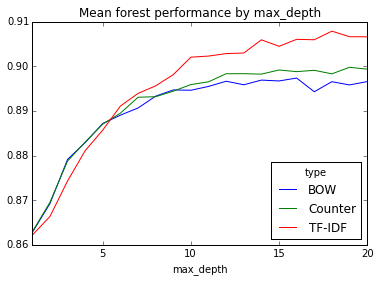

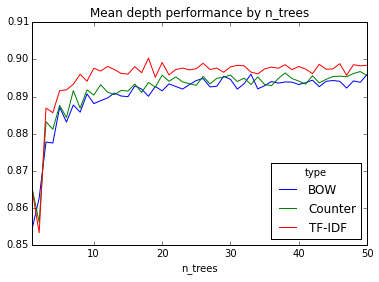

In [30]:
unstacked.pivot_table(
    values='mean', index='max_depth', columns='type', aggfunc='mean'
).plot(title='Mean forest performance by max_depth')

unstacked.pivot_table(
    values='mean', index='n_trees', columns='type', aggfunc='mean'
).plot(title='Mean depth performance by n_trees')

/Library/Anaconda3/anaconda/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


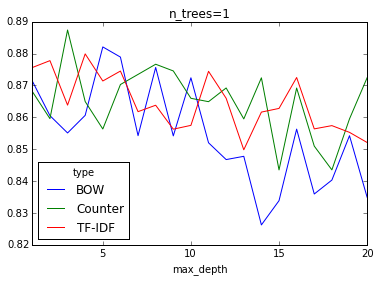

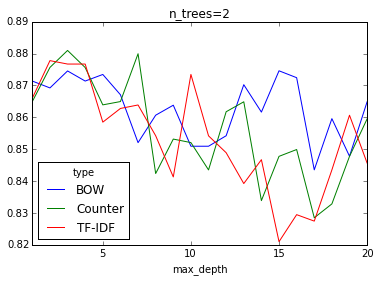

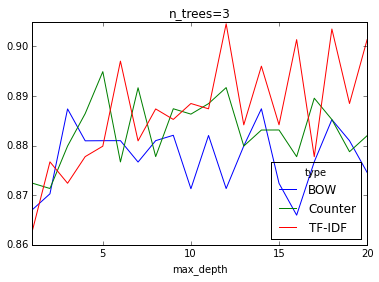

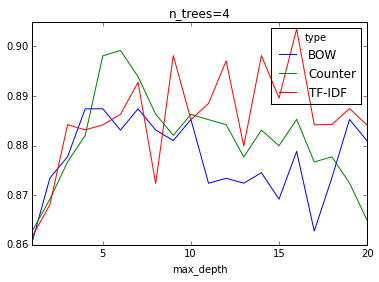

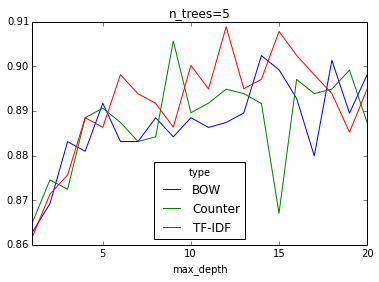

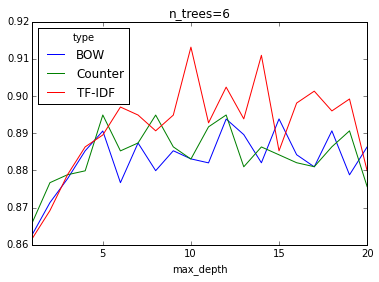

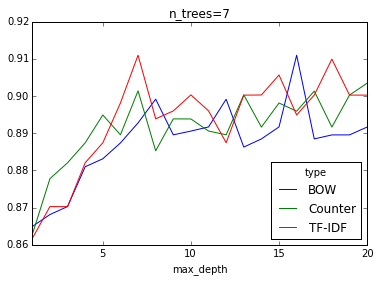

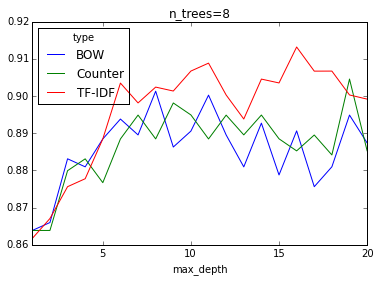

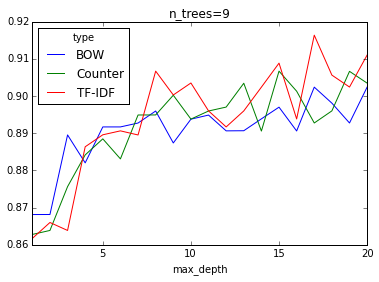

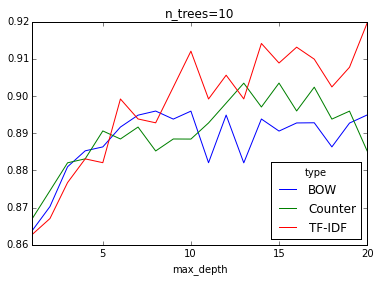

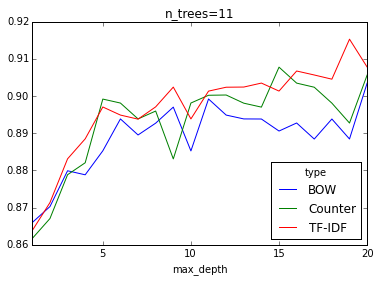

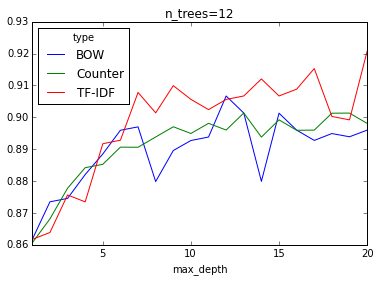

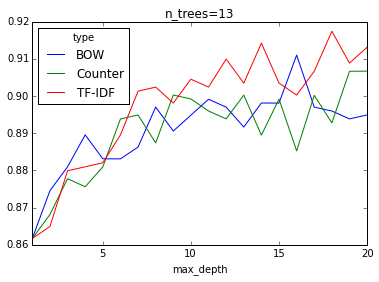

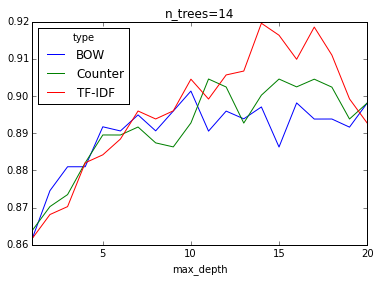

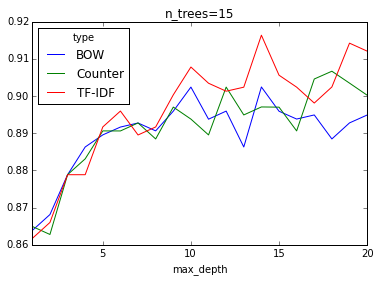

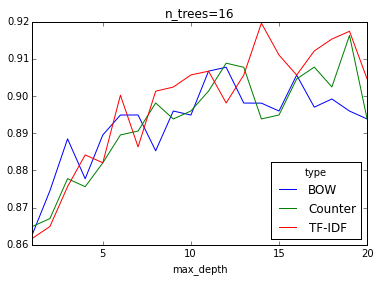

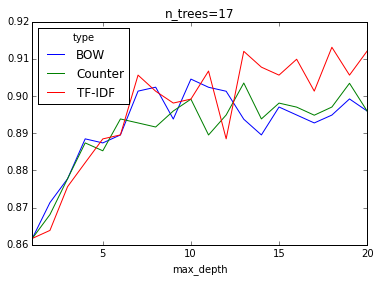

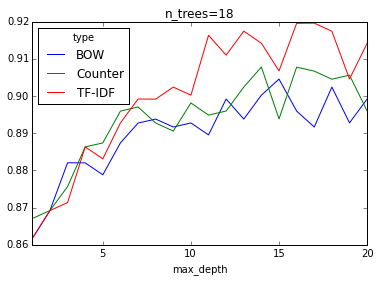

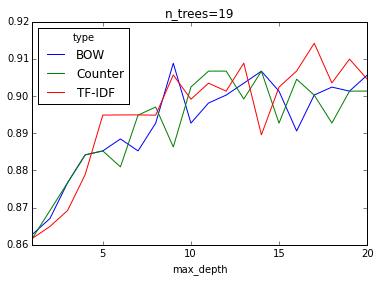

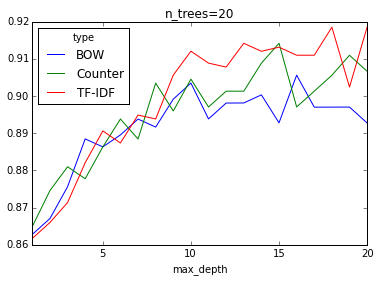

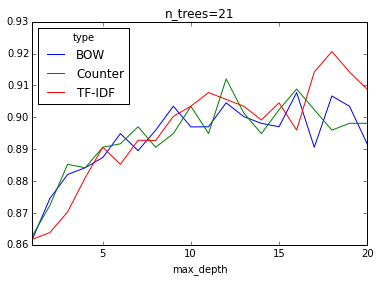

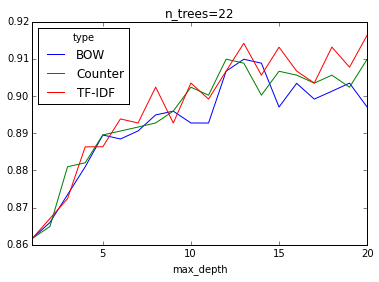

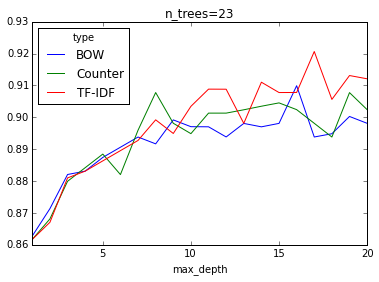

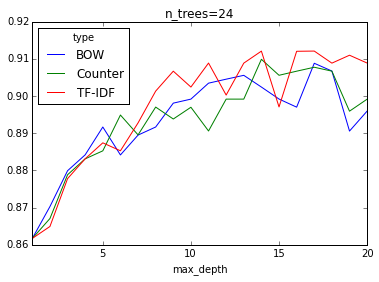

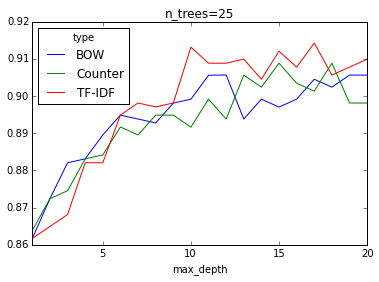

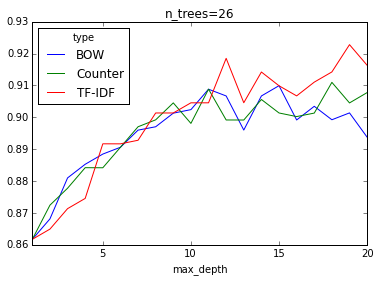

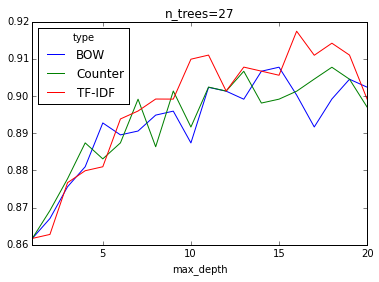

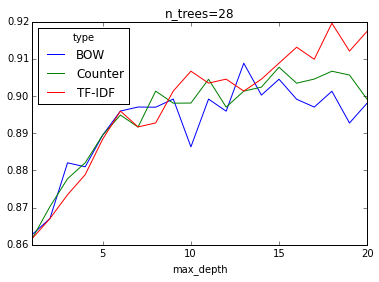

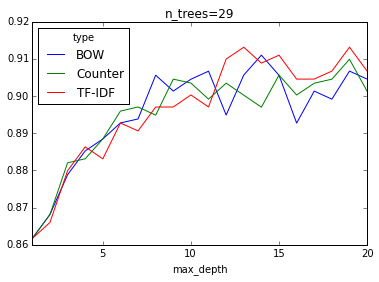

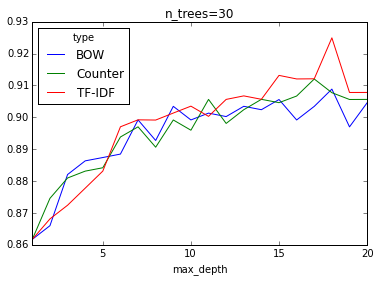

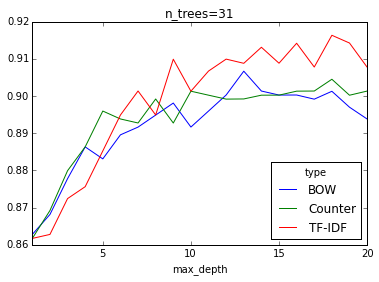

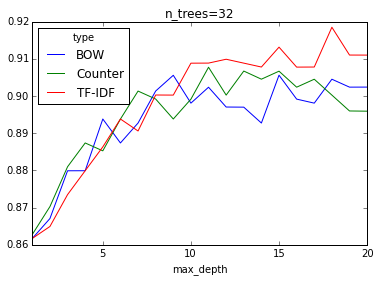

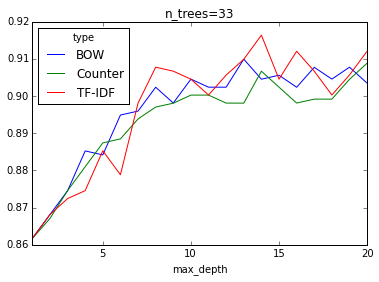

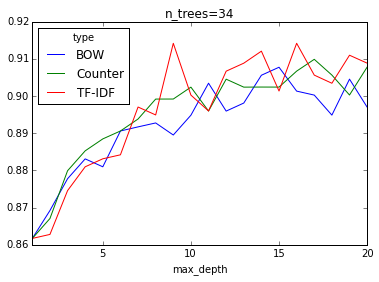

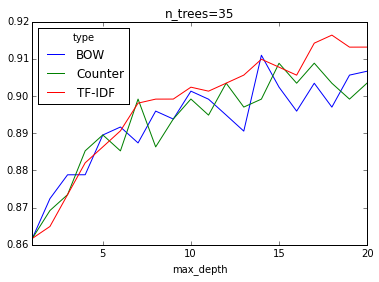

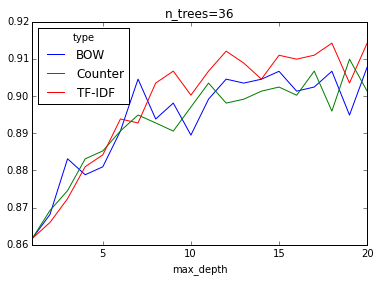

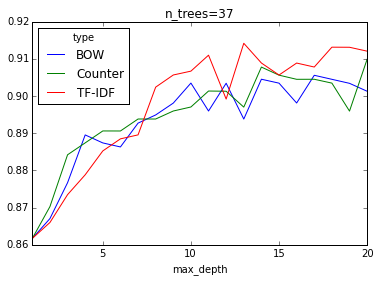

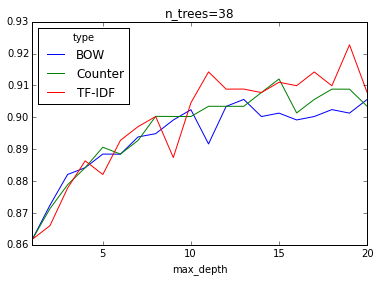

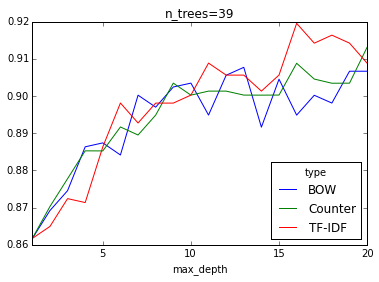

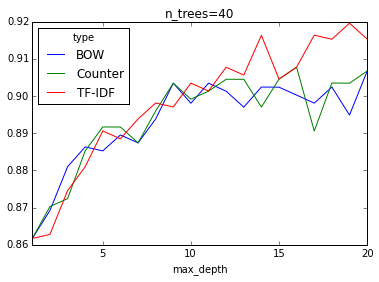

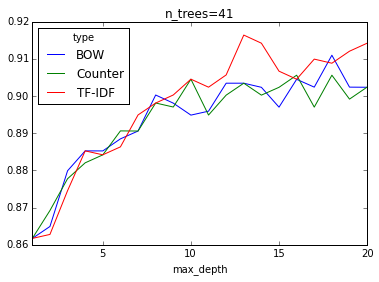

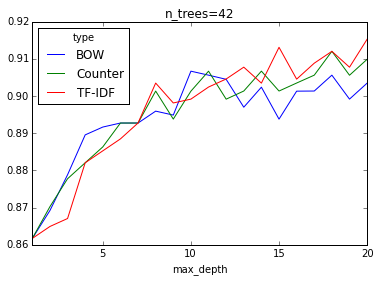

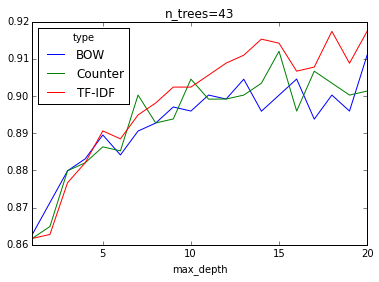

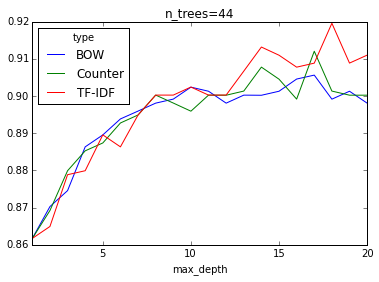

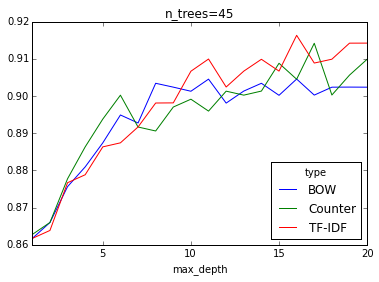

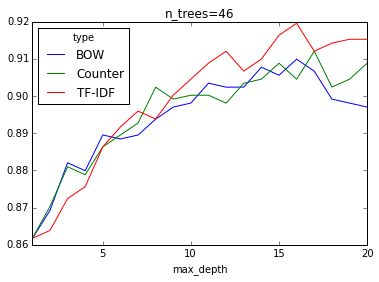

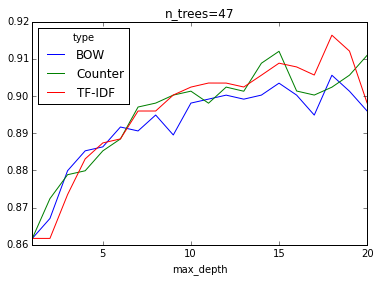

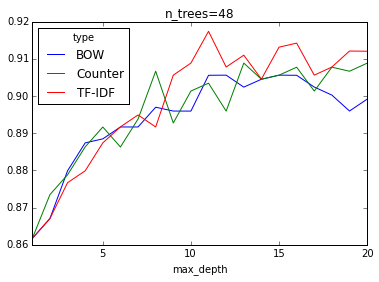

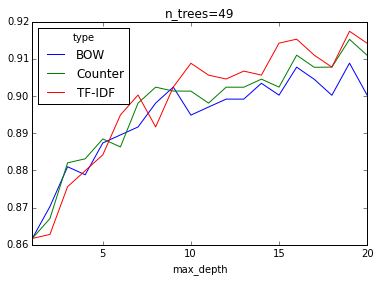

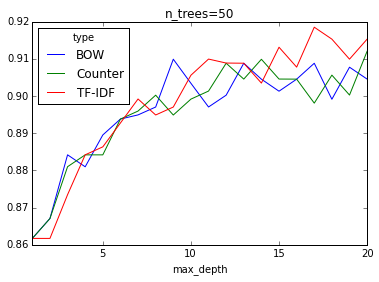

In [31]:
for n_trees in range(n_trees_interval[0], n_trees_interval[1] + 1):
    unstacked[
        unstacked['n_trees'] == n_trees
    ].pivot_table(
        values='mean', index='max_depth', columns='type'
    ).plot(title='n_trees=%d' % n_trees)

There's stability with 35+ trees

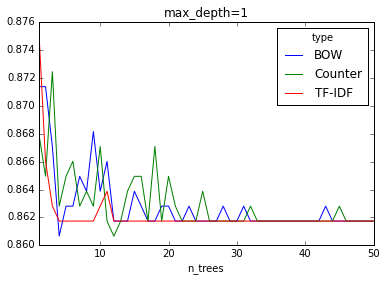

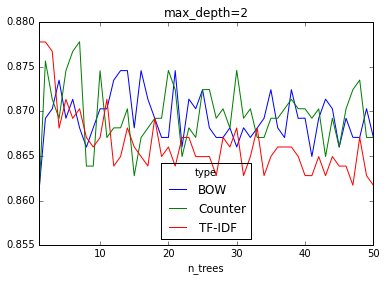

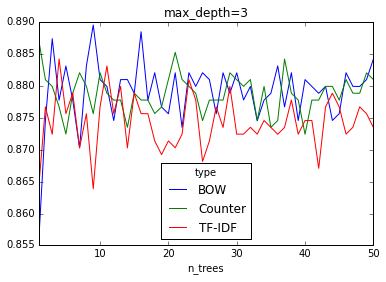

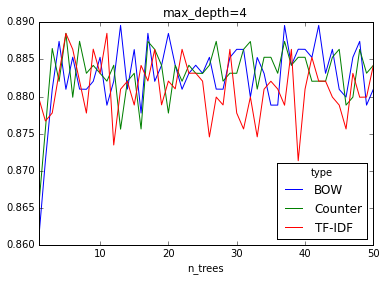

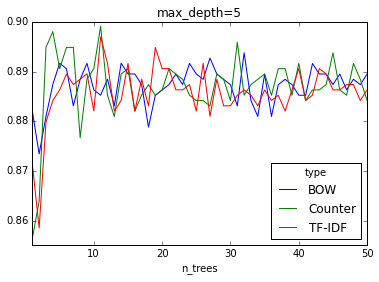

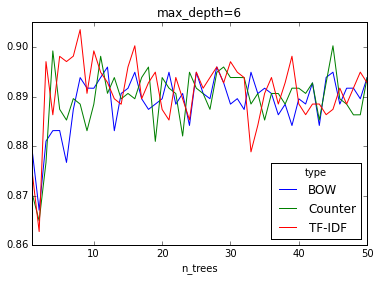

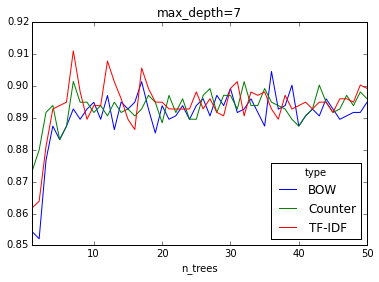

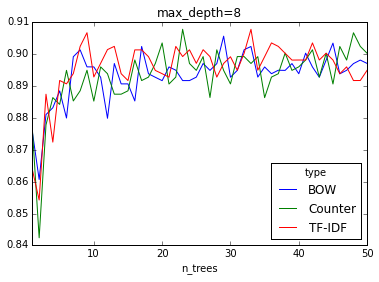

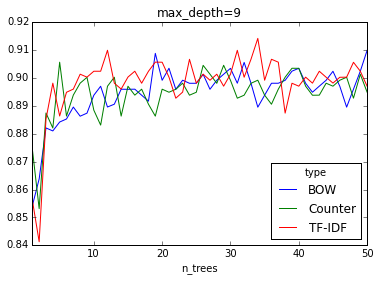

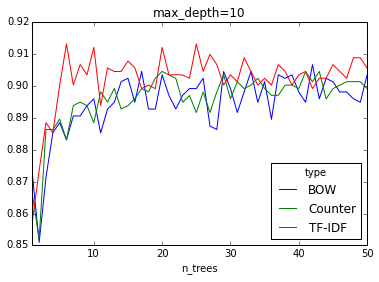

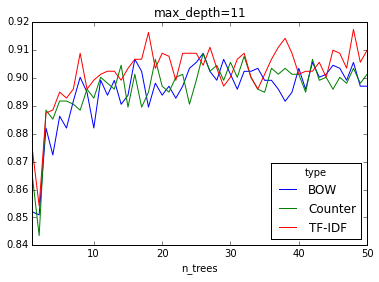

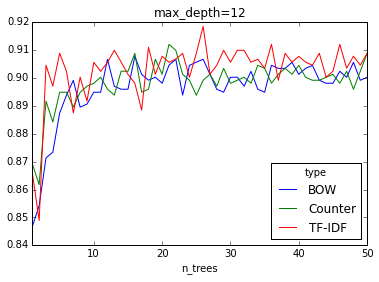

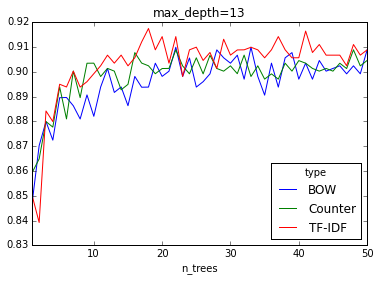

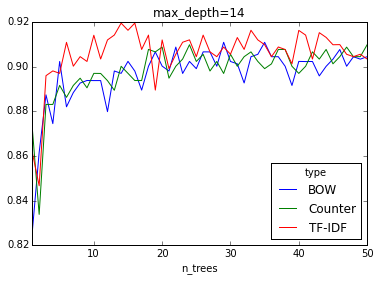

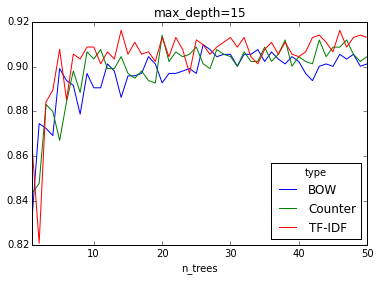

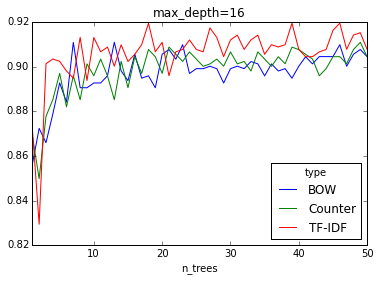

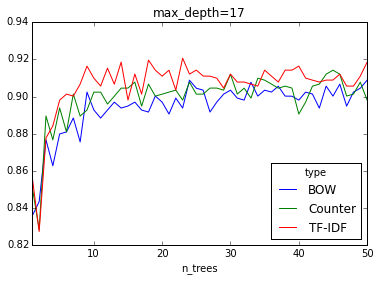

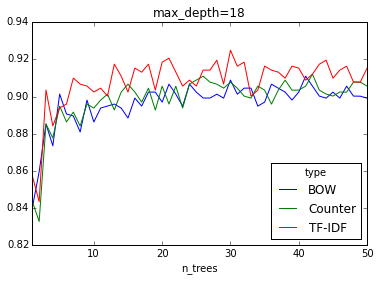

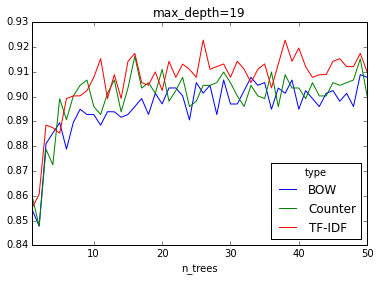

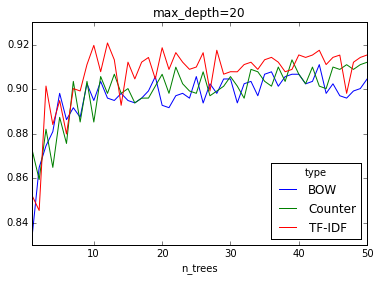

In [32]:
for max_depth in range(max_depth_interval[0], max_depth_interval[1] + 1):
    unstacked[
        (unstacked['max_depth'] == max_depth)
    ].pivot_table(
        values='mean', index='n_trees', columns='type'
    ).plot(title='max_depth=%d' % max_depth)

There's stability with max_depth of 10+

# Picking a model

It can be seen how both methods have a top-bound of 0.92 in terms of score, 
with similar confidence intervals. Also, Counter and TF-IDF seem to be equal
when working with Random Forests, which isn't the case in Naive Bayes, 
where Counter outperforms both BOW and TF-IDF.

In terms of speed, let's compare MultinomialNB and RandomForests(n_trees=40, max_depth=20), both with Counter

## MultinomialNB with Counter

Contruction of model:

In [33]:
clf = MultinomialNB()
%timeit clf.fit(X_Counter, Y)

100 loops, best of 3: 7.64 ms per loop


Evaluation:

In [34]:
%timeit clf.predict(X_Counter)

100 loops, best of 3: 4.7 ms per loop


## RandomForests(n_trees=40, max_depth=20) with Counter

Construction of model:

In [35]:
clf = RandomForestClassifier(n_estimators=40, max_depth=20)
%timeit clf.fit(X_Counter, Y)

1 loops, best of 3: 223 ms per loop


Evaluation:

In [36]:
%timeit clf.predict(X_Counter)

100 loops, best of 3: 14.7 ms per loop


## Conclusion

Being that the case, I pick MultinomialNB with Counter for the model, <br />
since it provides equivalent accuracy with better performace

# Building the model

In [37]:
clf = MultinomialNB()
clf.fit(X_Counter, Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
import os.path
from sklearn.externals import joblib

joblib.dump(clf, os.path.join('politics_model', 'politics_model.pkl'))

['politics_model/politics_model.pkl',
 'politics_model/politics_model.pkl_01.npy',
 'politics_model/politics_model.pkl_02.npy',
 'politics_model/politics_model.pkl_03.npy',
 'politics_model/politics_model.pkl_04.npy',
 'politics_model/politics_model.pkl_05.npy']

In [41]:
with open(os.path.join('politics_model', 'words.txt'), 'w') as f:
    f.write('\n'.join(WORDS))